# TDDE70 lab 3: Graph Neural Networks
The aim with this lab is that you get to familiarize yourself a bit more with graph neural networks (GNNs). You will do some theoretical work, using the message passing neural network-framework presented in the lectures, but mostly you will put this into practice and implement a GNN using [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/#) (PyG), which is a library built on top of PyTorch for working with GNNs of all kinds. 

**NOTE**: For this lab, use the conda environment called ```lab3```.

## Load required packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from utils import load_toy_data, generate_otf_graph

from coll_data import get_coll_loaders, batch_to_atoms

import ase

## Task 0: Data and batching in PyG
PyG is built on top of PyTorch, and in that sense is very similar to what you have already seen. However, graphs are structured a bit differently compared to, e.g., images. For example, the sizes of different samples can be very different, and a graph consists of different parts like node features, edges, and edge features. PyG helps keeping track and organize this using ```pyg.data.Data``` (for a single instance of a graph) and ```pyg.loader.DataLoader``` (a custom DataLoader for batching data).

### Data
First, lets take a look at two toy graphs, illustrated below. The numbers represent indices, and the colors indicate the type of the node.

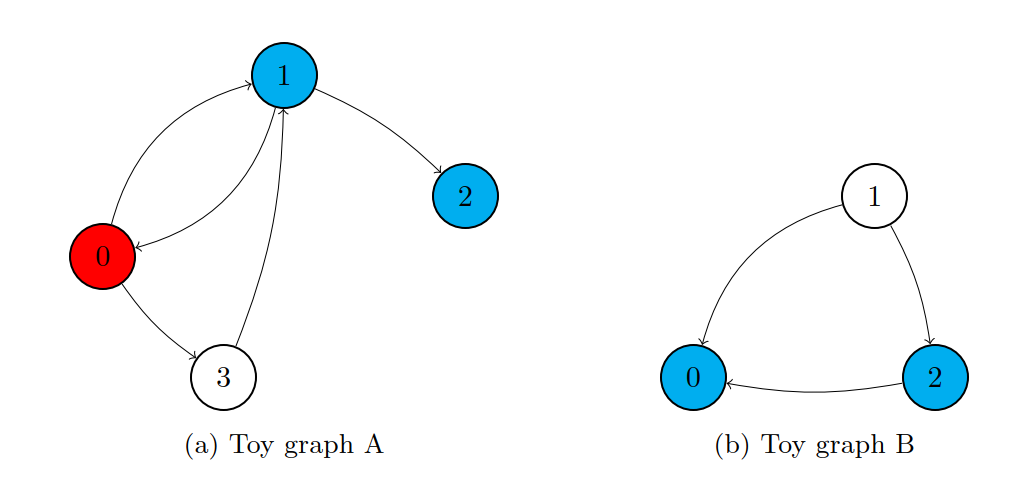



PyG representations of these can be loaded using ```load_toy_data()``` which returns the two graphs as ```pyg.data.Data``` objects. Try printing the contents, then answer the questions below.


In [ ]:
data1, data2 = load_toy_data()

In [ ]:
# play around
print(data1)
print('------')
print(data1.edge_index.shape,'\n' ,data1.x.shape)
print()
print(data2.edge_index,'\n' ,data2.x)

**Question:** Which of ```data1``` and ```data2``` correspond to graph A and B? Include a short motivation based on the output of your code.

Answer: Data1 have 4 nodes and 5 edges which correlates graph A, same resoning goes for B

### Batching
Now, let's take a look at how batching works in PyG. Create a PyG dataloader with ```data1``` and ```data2``` and 
check the content of the resulting batch to answer the two questions below.

In [ ]:
# create dataloader
dataloader = pyg.loader.DataLoader([data1, data2], batch_size=2)
data_batch = next(iter(dataloader))

In [ ]:
# play around with data_batch
print(data_batch)
print("----")
print(data_batch.batch)
print(data_batch.edge_index)

for data_batch in iter(dataloader):
    print(data_batch)
    print("*******")
    print(data_batch[0].edge_index,'\n' ,data_batch[0].x)
    print()
    print(data_batch[1].edge_index,'\n' ,data_batch[1].x)


In [ ]:
for data_batch in iter(dataloader):
    print(data_batch.edge_index)
    print(data_batch.batch)
    print(data_batch)

**Question**: What is the purpose of the ```batch``` attribute in ```data_batch```?



**Answer:** Batch seems to represent the number of nodes in the current batch, it also allows you to see how many atoms there are in different molekyles thats part of the batch

**Question**: What happened to ```edge_index``` when batching the two graphs? Why?



**Answer**: tensor([[1, 0, 3, 1, 0, 5, 6, 5, 8, 9, 8],
        [0, 1, 1, 2, 3, 4, 4, 6, 7, 7, 9]]) The edges between the number keep the same structure but for example on edge connects between node 5 and 4 and this is because the node numbering keeps increasing between the different molecules

## Task 1: Deriving MPNN equations
PyG provides support for the message passing neural network (MPNN) framework. Therefore, it is rather straight forward to implement a GNN if you have derived the functions $M_t$ and $U_t$ from the MPNN framework.

In this lab, you will work with a GNN called [CGCNN](https://arxiv.org/pdf/1710.10324.pdf) and which has been developed for chemistry applications. To implement this model in PyG, we will start by deriving the MPNN equations for CGCNN. In the original paper, they use the equation (compare eq. 5 in the paper)
$$
\mathbf{h}_i^{(l+1)}  = \mathbf{h}_i^{(l)} + \sum_{j\in\mathcal{N}(i)}\sigma(W_f^{(l)}\mathbf{z}^{(l)}_{i,j} + b_f^{(l)})\odot g(W_s^{(l)}\mathbf{z}_{i,j}^{(l)} + b_s^{(l)})
$$
to describe their updates to the node features $\mathbf{h}_i$. Here, $W$ and $b$ denote weight matrices and vectors, respectively, $\sigma()$ and $g()$ are functions operating element-wise, $\odot$ means element-wise multiplication, and $\mathbf{z}_{i, j} = \mathbf{h}_i \oplus \mathbf{h}_j \oplus \mathbf{e}_{i,j}$ is the concatenation of node and edge feature vectors.

**Question**: Given the equation above, re-write this according to the MPNN-equations from the lectures

**Answer**:
$$
M_t(\mathbf{h}_i^{(l)}, \mathbf{h}_j^{(l)}, \mathbf{e}_{i,j}^{(l)}) =  \sigma(W_f^{(l)}\mathbf{z}^{(l)}_{i,j} + b_f^{(l)})\odot g(W_s^{(l)}\mathbf{z}_{i,j}^{(l)} + b_s^{(l)})
$$

\sum_{j\in\mathcal{N}(i)}\sigma(W_f^{(l)}\mathbf{z}^{(l)}_{i,j} + b_f^{(l)})\odot g(W_s^{(l)}\mathbf{z}_{i,j}^{(l)} + b_s^{(l)})

$$
U_t(\mathbf{h}_i^{(l)}, \mathbf{m}_i^{(l)}) = \mathbf{h}_i^{(l)} + \mathbf{m}_i
$$

**Question**: To what "flavor" of GNNs (see slides, or the [GDL](https://arxiv.org/pdf/2104.13478) book chapter 5.3) does CGCNN belong to? Include a short motivation

**Answer:** It does not fulfull the restrictions for convultional or attention so it must be a MPNN

# Task 2: Implementing a CGCNN layer
Now it is time to put these equations into practice and create a CGCNN layer, using the ```MessagePassing``` class from PyG.

First, if you have not already, please read through the **intro** and the **part about the Messsage Passing base class** in the PyG [tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html). **Note**: the function ```MessagePassing.update()``` has according to the developers been phased out. We make the update inside ```forward``` instead, after having called ```propagate().```

Then implement the equations that you derived. In the CGCNN paper, it is specified that $\sigma(\cdot) = \text{sigmoid}(\cdot)$ to implement a _gating_ mechanism. For $g(\cdot)$, we can use $\text{softplus}(\cdot)$


In [ ]:
class CGCNNLayer(pyg.nn.MessagePassing):
    def __init__(self, node_fea_dim, edge_fea_dim):
        # choose appropiate aggregation function
        super().__init__(aggr= "sum") # aggregation function of messages
        self.linear1 = nn.Linear(node_fea_dim*2+edge_fea_dim, node_fea_dim)
        self.linear2 = nn.Linear(node_fea_dim*2+edge_fea_dim, node_fea_dim)
        self.batchnorm3 = nn.BatchNorm1d(node_fea_dim, node_fea_dim*2+edge_fea_dim)
        self.batchnorm2 = nn.BatchNorm1d(node_fea_dim, node_fea_dim*2+edge_fea_dim)
        self.batchnorm1 = nn.BatchNorm1d(node_fea_dim, node_fea_dim*2+edge_fea_dim)
        # Set up necessary components for one layer

        # Batch norm is not included in the MPNN equations, but should be applied on two occasions:
        # 1. Before sigma and g are applied
        # 2. On the message (after aggregation, i.e., from whatever is returned from self.propagate)

    def forward(self, h, edge_index, edge_attr):
        # call propagate
        # edge_index always need to be included, then we can add names arguments that will be passed to, e.g., message
        out = self.propagate(edge_index, h=h, e=edge_attr)
        
        # remember batch norm on output from propagate
        out = self.batchnorm1(out)
        # update (U_t):
        out = h + out
        # return the updated features
        return out

    def message(self, h_i, h_j, e):
        # implementation of M_t
        
        z = torch.cat((h_i, h_j, e), dim = 1)
    
        M = torch.sigmoid(self.batchnorm2(self.linear1(z)))*F.softplus(self.batchnorm3(self.linear2(z)))
        # appending _i or _j to name of a variable that was passed to propagate will map it to the corresponding node
        
        return M

# Task 3: Finalizing CGCNN
Now once we have implemented the layer, we can use it in a full CGCNN model. This is still a ```torch.nn.Module``` (so nothing new just because we are working with GNNs), but the layers will be instances of your ```CGCNNLayer``` from before. As such, the ```forward()``` function should do the following (see also ```CGCNN_block_diagram.pdf``` for a visual illustration)

1. Embed the nodes into node features
1. Iterate over the CGCNN layers
    1. Pass through the layer
    1. Batch norm
    1. Activation function (for example, softplus)
1. Pool node features
1. Pass pooled representation through final MLP

To perform the pooling of node features, PyG provides [pooling layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#pooling-layers). CGCNN uses mean pooling, so take a look at the documentation of [pyg.nn.pool.global_mean_pool](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_mean_pool.html#torch_geometric.nn.pool.global_mean_pool)

In [ ]:
class CGCNN(nn.Module):
    def __init__(self, node_fea_dim, edge_fea_dim, num_layers, cutoff, max_neighbors):
        # feel free to add more arguments if you think it is necessary for your implementation
        super().__init__()
        self.cutoff = cutoff
        self.max_neighbors = max_neighbors
        self.pbc = False  # Keep this when using the COLL dataset
        assert edge_fea_dim in [1, 3]
        self.edge_fea_dim = edge_fea_dim

        # Create an embedding layer (the maximum atom number will be less than 100, so use num_embeddings=100)
        self.embedding = nn.Embedding(num_embeddings=100, embedding_dim=node_fea_dim)
        self.activation = nn.Softplus()
        # Initialize the cgcnn layers, batch norm layers, and choose an activation function
        # Hint: nn.ModuleList can be useful if you don't want to use nn.Sequential
        
        self.layers = nn.ModuleList()
        for layer in range(0, num_layers):
            self.layers.append(CGCNNLayer(node_fea_dim, edge_fea_dim))
            self.layers.append(nn.BatchNorm1d(node_fea_dim, node_fea_dim*2+edge_fea_dim))
            self.layers.append(self.activation)
            
        # Pool function
        self.pool = pyg.nn.pool.global_mean_pool
        # Create a small MLP that can take in the pooled representation, and output a prediction of the energy
        self.out_mlp = nn.ModuleList()
        self.out_mlp.append(nn.Linear(node_fea_dim, node_fea_dim*2+edge_fea_dim))
        self.out_mlp.append(nn.ReLU())
        self.out_mlp.append(nn.Linear(node_fea_dim*2+edge_fea_dim, 1))
                                

    def forward(self, data):
        # For this data, we construct the graph on the fly, but it is possible for other datasets to have data.edge_index, data.edge_attr etc
        edge_index, edge_dist, distance_vec = generate_otf_graph(data, self.cutoff, self.max_neighbors, self.pbc)
        edge_dist = edge_dist.unsqueeze(-1)
            
        if self.edge_fea_dim == 1:
            edge_attr = edge_dist
        else:
            edge_attr = distance_vec

        embedding = self.embedding(data.atomic_numbers)
        cgcnn = embedding
        counter = 0
        for layer in self.layers:
            if counter % 3 == 0:
                cgcnn = layer(cgcnn, edge_index, edge_attr)
            else:
                 cgcnn = layer(cgcnn)
            counter +=1
            
        pooled = self.pool(cgcnn, data.batch)
        mlp = pooled
        for layer in self.out_mlp:
            mlp = layer(mlp)

        return mlp
        # Implement the different steps in the forward pass
        # atomic numbers are stored in data.atomic_numbers

## Invariance
The task for the GNN in this lab is to predict the energy of the molecular system. This property is __invariant__ to any rigid transformations (i.e., rotations and/or translations) of the molecules; it does not matter if we move the molecule to a different position, or if it is rotated, it is still the same molecule with the same energy.

We can make the network invariant to such transformations by using only invariant features. The input to CGCNN consists of the atom types $\mathbf{z}$ (node features) and the atom positions $\mathbf{X}$. The atom types are of course invariant to translations and rotations, so it is the geometric information in $\mathbf{X}$ that needs consideration. CGCNN incorporates this geometric information in the edge features. Consider using as edge feature either 1) the distance between the two atoms or 2) the (three-dimensional) vector between the atoms

**Question:** To what transformations (rotations, translations) are these respective features invariant? For translations both will be invariant.

**Answer:** For rotations the distance should remain the same. But the 3D vector will differ. 

Now let's take a look at this in practice. Load some data and use ```transform_and_visualize``` to apply a rotation and see how it looks like.

**Note**: the dataset we are working on in this lab is called COLL. You do not have to implement the dataset yourself, but PyG provides a custom dataset class called ```InMemoryDataset``` in which COLL has been implemented for this lab. If you are interested in how such a dataset could be constructed, you can take a look at ```coll_data.py``` to see the implementation, and you can read more in the [PyG tutorial on creating graph datasets](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html).

In [ ]:
def transform_and_visualize(data):
    transformed_data = data.clone()
    rot_vec = np.array([1.0, 1.0, 0.0])
    rot_vec = rot_vec / np.linalg.norm(rot_vec)
    rot_angle = np.pi/3
    rotation_matrix = torch.tensor(Rotation.from_rotvec(rot_angle * rot_vec).as_matrix()).float()
    transformed_data.pos = torch.matmul(transformed_data.pos, rotation_matrix)
    fig, ax = plt.subplots(1, 2)
    atoms = batch_to_atoms(data)
    transformed_atoms = batch_to_atoms(transformed_data)

    ase.visualize.plot.plot_atoms(atoms[0], ax[0], rotation=("-75x, 45y, 10z"))
    ase.visualize.plot.plot_atoms(transformed_atoms[0], ax[1], rotation=("-75x, 45y, 10z"))

    ax[0].set_title("Original data")
    ax[1].set_title("Rotated data")
    plt.show()
    return data, transformed_data
    
    

In [ ]:
_, loader, _ = get_coll_loaders(5)  # returns train, val, test loaders. For now just using the val loader

data = next(iter(loader))

data, transformed_data = transform_and_visualize(data)

In [ ]:
print(data)
print(data.pos.shape[1])

Now try instatiating a model that uses these different edge features by setting ```edge_fea_dim=1``` (only distances) or ```edge_fea_dim=3``` (vector between atoms), and make predictions for both ```data``` and ```transformed_data```. 

In [ ]:
# Reasonable values for cutoff and max_neighbors are 12 [Å] and 30, respectively. For now, number of layers doesn't matter
model1 = CGCNN(1, 1, 3, 12, 30)
model3 = CGCNN(1, 3, 3, 12, 30)
with torch.no_grad():
    print(model1(data), "\n", model1(transformed_data))
    print()
    print(model3(data), "\n", model3(transformed_data))

In [ ]:
print(model1(data))
print(model1)

# Task 4: Train a CGCNN model

## Invariant model
Now it is time to train a model. Start with a completely invariant model (```edge_fea_dim=1```). After loading the data, initialize your model, choose an optimizer and loss function. As mentioned in Lab 1, creating a Trainer class is typically very convenient, but not strictly necessary. You are free to use the very simple train and validate functions below, but you can of course modify the code to implement a trainer yourself.

In [ ]:
train_loader, val_loader, test_loader = get_coll_loaders(128)

In [ ]:
@torch.inference_mode()
def validate(model, loader, device):
    assert not model.training, "Model is in training mode"
    num_samples = 0
    total_sq_error = 0
    total_abs_error = 0
    for i, batch in enumerate(loader):
        batch = batch.to(device)
        batch_size = batch.y.shape[0]
        num_samples += batch_size
        pred = model(batch)
        mae = F.l1_loss(pred, batch.y)
        mse = F.mse_loss(pred, batch.y)

        total_sq_error += mse.item()*batch_size
        total_abs_error += mae.item()*batch_size
    avg_mse = total_sq_error / num_samples
    avg_mae = total_abs_error / num_samples
    return avg_mse, avg_mae

def train_and_test(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=10, device="cuda", save_name="best_parameters.pt", test_loader=None):
    model = model.to(device)
    model.train(True)
    best_val_error = 1e9

    for epoch in range(num_epochs):
        epoch_losses = []
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            batch = batch.to(device)

            pred = model(batch)
            loss = loss_fn(pred, batch.y)

            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        mean_epoch_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch} training loss: \t {mean_epoch_loss:.4f}")

        # Validation
        model.train(False)
        val_mse, val_mae = validate(model, val_loader, device) 
        print(f"Epoch {epoch} validation MSE: {val_mse:.4f} \t MAE: {val_mae:.4f}")
        if val_mae < best_val_error:  # we choose MAE as preferred metric
            torch.save(model.state_dict(), save_name)  # save these model parameters
            best_val_error = val_mae
        model.train(True)
    print("Training finished!")
    model.train(False)
    if test_loader is not None:
        print("Evaluating on test set")
        model.load_state_dict(torch.load(save_name))  # load best parameters, based on validation error (early stopping)
        test_mse, test_mae = validate(model, test_loader, device)
        print(f"Final test MSE: {test_mse:.4f}, \t MAE {test_mae:.4f}")

In [ ]:
# Reasonable values for cutoff and max_neighbors are 12 [Å] and 30, respectively
# feel free to play around with number of layers, hidden dimensions, and optimizer
model = CGCNN(256, 1, 5, 12, 30)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
loss_fn = F.mse_loss
train_and_test(model, optimizer, loss_fn, train_loader, val_loader, 10, "cuda", "best_parameters_invariant.pt", test_loader)

## Not using an invariant model
Now compare this to a model that is not completely invariant (i.e., ```edge_fea_dim=3```)

In [ ]:
# use same setup as before, only change type of edge features
model = CGCNN(256, 3, 5, 12, 30)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
loss_fn = F.mse_loss
train_and_test(model, optimizer, loss_fn, train_loader, val_loader, 10, "cuda", "best_parameters_non_invariant.pt", test_loader)

**Question:** Do you see any differences in performance compared to the invariant model? Why do you think that is the case?

**Answer:** The result is fairly similar, slightly worse for the invariant model, assume that it is because the rotations etc matter.

**Question:** In this case we could make the model invariant by design. If that is not possible, could you think of some other option(s) for making a model more robust to transformations of the input? (Apart from transformations discussed in this lab, another example could be to make a CNN robust to rotations of an image, e.g., a cat is always a cat, even if it is upside down)

 By preprocessing the data, by for example using molekueles with different rotations and let them have the same label. 